In [189]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linesearch

# 去除 DeprecationWarning等类似警告
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [190]:
# 表示 f(x)
def f(x):
    out = 100 * (x[0]**4) + (1 - x[0]) ** 2
    out += 100 * (x[1] ** 2) - 200 * (x[0] ** 2) * x[1]
    out += 100 * (x[2]**4) + (1 - x[2]) ** 2
    out += 100 * (x[3] ** 2) - 200 * (x[2] ** 2) * x[3]

    return np.array([out])

# 返回f(x)的梯度
def grad_f(x):
    x1 = 400 * (x[0][0] ** 3) - 400 * x[0][0] * x[1][0] + 2 * x[0][0] - 2
    x2 = 200 * x[1][0] - 200 * (x[0][0] ** 2)
    x3 = 400 * (x[2][0] ** 3) - 400 * x[2][0] * x[3][0] + 2 * x[3][0] - 2
    x4 = 200 * x[3][0] - 200 * (x[2][0] ** 2)

    return np.array([[x1, x2, x3, x4]]).T

# 调用line_search_wolfe2的梯度
def grad_w(x):
    return grad_f(x).T

In [191]:
# wolfe准则
def WOLFE(xk, dk):
    rho = 0.1
    sigma = 0.9
    a = 0
    b = np.inf
    alpha = 1

    while True:
        if not ((f(xk) + rho * alpha * grad_f(xk).T @ dk)[0][0] >= f(xk + alpha * dk)[0][0]):
            b = alpha
            alpha = (a + alpha) / 2
            continue
        if not ((grad_f(xk + alpha * dk).T @ dk)[0][0] >= (sigma * grad_f(xk).T @ dk)[0][0]):
            a = alpha
            alpha = np.min([2 * alpha, (alpha + b) / 2])
            continue
        break

    return alpha

In [192]:
# 拟牛顿法
def Quasi_Newton(flag):
    # 初始化
    xk = np.array([[1.2, 1, 1, 1]]).T
    Hk = np.array([[0.1, 0, 0, 0], [0, 0.1, 0, 0], [0, 0, 0.1, 0], [0, 0, 0, 0.1]])
    out_f = []

    fk = f(xk)
    # out_f.append(fk[0][0])

    i = 0
    while f(xk) > 1e-8:
        i += 1
        # 计算搜索方向
        dk = - Hk @ grad_f(xk)

        # 更新迭代点
        # alpha = WOLFE(xk, dk)

        # 调用scipy.optimize实现强wolfe准则
        alpha = linesearch.line_search_wolfe2(f, grad_w, xk, dk)[0]
        
        bf_xk = np.array(xk)
        xk += alpha * dk

        # 更新矩阵
        sk = xk - bf_xk
        yk = grad_f(xk) - grad_f(bf_xk)
        if flag == 1:
            Hk = Hk + ((sk - Hk @ yk) @ (sk - Hk @ yk).T) / ((sk - Hk @ yk).T @ yk)
        elif flag == 2:
            Hk = Hk + (sk @ sk.T) / (sk.T @ yk) - (Hk @ yk @ yk.T @ Hk) / (yk.T @ Hk @ yk)
        elif flag == 3:
            Hk = Hk + (1 + (yk.T @ Hk @ yk)/ (sk.T @ yk)) * ((sk @ sk.T) / (sk.T @ yk)) - ((sk @ yk.T @ Hk
            + Hk @ yk @ sk.T) / (sk.T @ yk))


        out_f.append(f(xk)[0][0])

    return out_f

In [193]:
# SR1
def SR1():
    return Quasi_Newton(1)

# DFP
def DFP():
    return Quasi_Newton(2)

# BFGS
def BFGS():
    return Quasi_Newton(3)

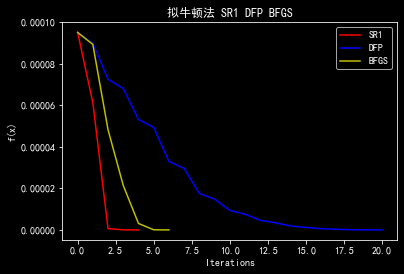

In [194]:
# 绘制图像
A = SR1()
B = DFP()
C = BFGS()

plt.plot(range(len(A)-3), A[3:], 'r', label = "SR1")
plt.plot(range(len(B)-3), B[3:], 'b', label = "DFP")
plt.plot(range(len(C)-3), C[3:], 'y', label = "BFGS")
plt.title('拟牛顿法 SR1 DFP BFGS')
plt.xlabel('Iterations')
plt.ylabel('f(x)')
plt.legend()#显示图例
plt.show()#显示图片